## 4.1.2 - Running regressions for all products in one model after clusterization

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from statistics import mean 

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import matplotlib.pyplot       as plt
import seaborn                 as sns

### Loading the cleaned dataset

In [2]:
df = pd.read_csv('../data/celular_over50.csv', dtype={'gtin':'str'})
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,competition_price,gtin,item_name,orders,olist_price,freight_value,price_ratio,freight_ratio,weekday_1,...,monthday_22,monthday_23,monthday_24,monthday_25,monthday_26,monthday_27,monthday_28,monthday_29,monthday_30,monthday_31
0,2019-07-14,419.90,6438409014344,Nokia 8110 4g dual chip amarelo .,1.0,419.9,24.23,1.000000,0.057704,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-07-15,419.90,6438409014344,Nokia 8110 4g Dual Chip Amarelo,1.0,419.9,24.23,1.000000,0.057704,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-07-21,377.91,6438409014344,Nokia 8110 4g Dual Chip Amarelo,1.0,419.9,24.23,1.111111,0.057704,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-07-27,377.91,6438409014344,Nokia 8110 4g dual chip amarelo .,1.0,419.9,42.58,1.111111,0.101405,0,...,0,0,0,0,0,1,0,0,0,0
4,2019-08-05,379.90,6438409014344,Nokia 8110 4g Dual Chip Amarelo,1.0,419.9,20.19,1.105291,0.048083,0,...,0,0,0,0,0,0,0,0,0,0


### Normalizing the prices and freights

In [3]:
df['competition_price_sc'] = df.groupby('gtin').competition_price.transform(lambda x: minmax_scale(x.astype(float)))
df['price_sc'] = df.groupby('gtin').olist_price.transform(lambda x: minmax_scale(x.astype(float)))
df['freight_sc'] = df.groupby('gtin').freight_value.transform(lambda x: minmax_scale(x.astype(float)))

### Group the data by product to check the clusters

Let's group data, trying to find some cluster, to avoid the regressions by gtin. In that way, we can classify all other products and use the regressions for generalization

In [4]:
price_ratio = pd.DataFrame(df.groupby('gtin')['price_ratio'].mean())
freight_ratio = pd.DataFrame(df.groupby('gtin')['freight_ratio'].mean())
total_orders = pd.DataFrame(df.groupby('gtin')['orders'].sum())

In [5]:
df_summary = price_ratio.merge(total_orders, on='gtin').sort_values('orders', ascending = False)
df_summary = df_summary.merge(freight_ratio, on='gtin').sort_values('orders', ascending = False)
df_summary.head()

,price_ratio,orders,freight_ratio
gtin,,,
7893299910340,0.981869,3417.0,0.005112
7893299910425,0.978969,3146.0,0.004572
7893299910418,1.015605,1239.0,0.012521
7892509104661,1.015379,1213.0,0.004321
7892509104586,1.005820,1101.0,0.003551


### Clusterizing

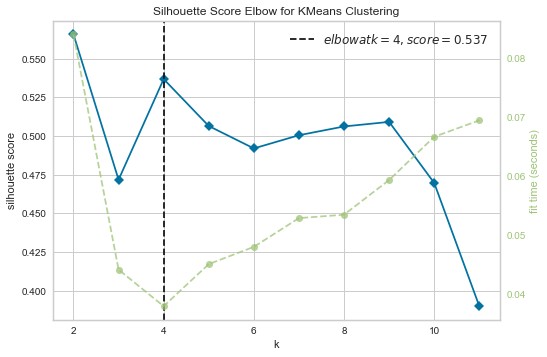

In [15]:
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette')

visualizer.fit(df_summary[['price_ratio', 'freight_ratio']])      # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [16]:
k = 4
km = KMeans(n_clusters = k, random_state = 171)
cluster = km.fit_predict(df_summary[['price_ratio', 'freight_ratio']])

df_summary['cluster'] = cluster

df_c = df.merge(df_summary['cluster'], on = 'gtin')

In [17]:
vars_cat = ['cluster']
df_dummies = pd.get_dummies(df_c, columns = vars_cat, drop_first=True)

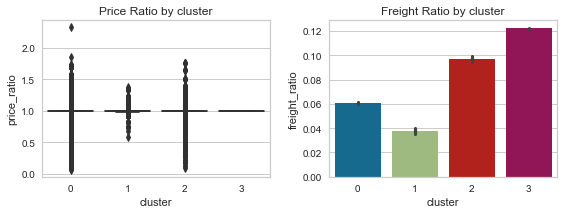

In [18]:
plt.subplot(2, 2, 1)
sns.boxplot(x = df_c.cluster, y = df.price_ratio)
plt.title('Price Ratio by cluster')

plt.subplot(2, 2, 2)
sns.barplot(x = df_c.cluster, y = df.freight_ratio)
plt.title('Freight Ratio by cluster')

plt.tight_layout()          
plt.show()

### Trying some regressions

In [19]:
mae = []
for i in range(0,100):
    train, test = train_test_split(df_c, test_size=0.8)
    formula = 'orders ~ price_sc + competition_price_sc + freight_ratio + C(cluster)'
    model = smf.ols(formula = formula, data = train).fit()
    mae.append(metrics.median_absolute_error(test['orders'], model.predict(test)))

mean(mae)    
#print(model.summary())
    

1.0859222199279288

In [21]:
mae = []
for i in range(0,100):
    train, test = train_test_split(df_c, test_size=0.8)
    formula = 'orders ~ price_ratio + freight_ratio + C(cluster)'
    model = smf.ols(formula = formula, data = train).fit()
    mae.append(metrics.median_absolute_error(test['orders'], model.predict(test)))

mean(mae)
#print(model.summary())
    

1.36537039987446

In [22]:
mae = []
for i in range(0,100):
    train, test = train_test_split(df_c, test_size=0.8)
    formula = 'orders ~ price_ratio + freight_value + C(cluster)'
    model = smf.ols(formula = formula, data = train).fit()
    mae.append(metrics.median_absolute_error(test['orders'], model.predict(test)))

mean(mae)    
#print(model.summary())
    

1.0202956476037042

In [23]:
mae = []
for i in range(0,100):
    train, test = train_test_split(df_c, test_size=0.8)
    formula = 'orders ~ price_ratio + freight_ratio + competition_price_sc + price_sc + freight_sc + weekday_1 + weekday_2 + weekday_3 +\
        weekday_4 + weekday_5 + weekday_6 + week_2 + week_3 + week_4 + week_5 + week_6 + week_7 + \
        week_8 + week_9 + week_10 + week_11 + week_12 + week_13 + week_14 + week_15 + week_16 + week_17 +\
        week_18 + week_19 + week_20 + week_21 + week_22 + week_23 + week_24 + week_25 + week_26 + week_27 +\
        week_28 + week_29 + week_30 + week_31 + week_32 + week_33 + week_34 + week_35 + week_36 + week_37 +\
        week_38 + week_39 + week_40 + week_41 + week_42 + week_43 + week_44 + week_45 + week_46 + week_47 +\
        week_48 + week_49 + week_50 + week_51 + week_52 + month_2 + month_3 + month_4 + month_5 + month_6 +\
        month_7 + month_8 + month_9 + month_10 + month_11 + month_12 + monthday_2 + monthday_3 + monthday_4 +\
        monthday_5 + monthday_6 + monthday_7 + monthday_8 + monthday_9 + monthday_10 + monthday_11 + monthday_12 +\
        monthday_13 + monthday_14 + monthday_15 + monthday_16 + monthday_17 + monthday_18 + monthday_19 +\
        monthday_20 + monthday_21 + monthday_22 + monthday_23 + monthday_24 + monthday_25 + monthday_26 +\
        monthday_27 + monthday_28 + monthday_29 + monthday_30 + monthday_31 + C(cluster)'
    model = smf.ols(formula = formula, data = train).fit()
    mae.append(metrics.median_absolute_error(test['orders'], model.predict(test)))

mean(mae)   
#print(model.summary())
    

1.4450113152647348

### Decision Trees

In [24]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]
mae = []

for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    treeregressor = DecisionTreeRegressor(max_depth = 5)
    tree_fit = treeregressor.fit(x_train, y_train)
    tree_pred = tree_fit.predict(x_test)
    mae.append(metrics.median_absolute_error(y_test, tree_pred))

mean(mae)

0.5356249364569953

In [25]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'price_ratio', 'freight_ratio', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]
mae = []

for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    treeregressor = DecisionTreeRegressor(max_depth = 5)
    tree_fit = treeregressor.fit(x_train, y_train)
    tree_pred = tree_fit.predict(x_test)
    mae.append(metrics.median_absolute_error(y_test, tree_pred))

mean(mae)

0.2981217979129538

In [26]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'price_ratio', 'freight_ratio', 
           'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]
mae = []

for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    treeregressor = DecisionTreeRegressor(max_depth = 5)
    tree_fit = treeregressor.fit(x_train, y_train)
    tree_pred = tree_fit.predict(x_test)
    mae.append(metrics.median_absolute_error(y_test, tree_pred))

mean(mae)

0.29870923746587064

In [27]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'price_ratio', 'freight_ratio', 
           'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'week_2', 'week_3', 'week_4',
            'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12', 'week_13',
            'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_20', 'week_21', 'week_22',
            'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30', 'week_31', 
            'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40', 
            'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 
            'week_50', 'week_51', 'week_52', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]
mae = []

for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    treeregressor = DecisionTreeRegressor(max_depth = 5)
    tree_fit = treeregressor.fit(x_train, y_train)
    tree_pred = tree_fit.predict(x_test)
    mae.append(metrics.median_absolute_error(y_test, tree_pred))

mean(mae)

0.30254671445119435

In [28]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'price_ratio', 'freight_ratio', 
           'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_2',
           'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 
           'month_11','month_12', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]
mae = []

for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    treeregressor = DecisionTreeRegressor(max_depth = 5)
    tree_fit = treeregressor.fit(x_train, y_train)
    tree_pred = tree_fit.predict(x_test)
    mae.append(metrics.median_absolute_error(y_test, tree_pred))

mean(mae)

0.3029531271913204

In [29]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'price_ratio', 'freight_ratio', 
            'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_2',
            'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 
            'month_11','month_12''monthday_2', 'monthday_3', 'monthday_4', 'monthday_5', 'monthday_6', 
            'monthday_7', 'monthday_8', 'monthday_9', 'monthday_10', 'monthday_11', 'monthday_12', 
            'monthday_13', 'monthday_14', 'monthday_15', 'monthday_16', 'monthday_17', 'monthday_18', 
            'monthday_19', 'monthday_20', 'monthday_21', 'monthday_22', 'monthday_23','monthday_24',
            'monthday_25', 'monthday_26', 'monthday_27', 'monthday_28', 'monthday_29', 'monthday_30',
            'monthday_31', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]
mae = []

for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    treeregressor = DecisionTreeRegressor(max_depth = 5)
    tree_fit = treeregressor.fit(x_train, y_train)
    tree_pred = tree_fit.predict(x_test)
    mae.append(metrics.median_absolute_error(y_test, tree_pred))

mean(mae)

0.2984557605575171

### Random Forest

After some hyperparameter adjusts, I found that. It's not better than decicion tree

In [30]:
sel_col = ['competition_price_sc', 'price_sc', 'freight_value_sc', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
treeregressor = RandomForestRegressor(n_estimators=1000, max_depth=5)
tree_fit = treeregressor.fit(x_train, y_train)
tree_pred = tree_fit.predict(x_test)
print(metrics.median_absolute_error(y_test, tree_pred))


0.5719581564295688


### SVM

In [31]:
sel_col = ['competition_price', 'olist_price', 'freight_value', 'price_ratio', 
           'freight_ratio', 'competition_price_sc', 'price_sc', 'freight_sc', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

regressor = SVR(C=1.0, epsilon=0.2)
fit = regressor.fit(x_train, y_train)
pred = fit.predict(x_test)
print('MAE: '+ str(metrics.median_absolute_error(y_test, pred)))

MAE: 0.19958512543062407


In [32]:
sel_col = ['competition_price', 'olist_price', 'freight_value', 'price_ratio', 'freight_ratio', 'weekday_1',
            'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'week_2', 'week_3', 'week_4',
            'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12', 'week_13',
            'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_20', 'week_21', 'week_22',
            'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30', 'week_31', 'week_32',
            'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
            'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_50', 'week_51', 'week_52',
            'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
            'month_12', 'monthday_2', 'monthday_3', 'monthday_4', 'monthday_5', 'monthday_6', 'monthday_7', 'monthday_8',
            'monthday_9', 'monthday_10', 'monthday_11', 'monthday_12', 'monthday_13', 'monthday_14', 'monthday_15', 'monthday_16',
            'monthday_17', 'monthday_18', 'monthday_19', 'monthday_20', 'monthday_21', 'monthday_22', 'monthday_23','monthday_24',
            'monthday_25', 'monthday_26', 'monthday_27', 'monthday_28', 'monthday_29', 'monthday_30', 'monthday_31','competition_price_sc',
            'price_sc', 'freight_sc', 'cluster_1', 'cluster_2', 'cluster_3']
y = df_dummies['orders']
x = df_dummies[df_dummies.columns.intersection(sel_col)]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

regressor = SVR(C=1.0, epsilon=0.2)
fit = regressor.fit(x_train, y_train)
pred = fit.predict(x_test)
print('MAE: '+ str(metrics.median_absolute_error(y_test, pred)))

MAE: 0.19971134624438974
